In [1]:
#import libraries
import pandas as pd
import numpy as np
import scipy as py
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['savefig.dpi'] = 144
plt.rcParams['figure.figsize'] = 14, 10
import math
import tensorflow as tf
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import multiprocessing
from keras.layers import Dropout
import random
np.random.seed(0)
tf.random.set_seed(1234)

In [2]:
def f(x):
    try:
        return np.float(x)
    except:
        return np.nan

def imputations(aqm_dw):
    for i in range(0,len(aqm_dw['month'])):
        if np.isnan(aqm_dw.iloc[i, 2]) :
            if aqm_dw.iloc[i, 4] == 1:
                np.random.seed(1)
                aqm_dw.iloc[i, 2] = random.uniform(100, 300) + random.uniform(0, (aqm_dw['PM2.5'].std()/2))
            elif aqm_dw.iloc[i, 4] == 2:
                np.random.seed(2)
                aqm_dw.iloc[i, 2] = random.uniform(50, 300) + random.uniform(0, (aqm_dw['PM2.5'].std()/2))
            elif aqm_dw.iloc[i, 4] == 11:
                np.random.seed(3)
                aqm_dw.iloc[i, 2] = random.uniform(400, 800) + random.uniform(0, (aqm_dw['PM2.5'].std()/2))
            elif aqm_dw.iloc[i, 4] == 12:
                np.random.seed(4)
                aqm_dw.iloc[i, 2] = random.uniform(150, 400) + random.uniform(0, (aqm_dw['PM2.5'].std()/2))
            elif aqm_dw.iloc[i, 4] == 10:
                np.random.seed(5)
                aqm_dw.iloc[i, 2] = random.uniform(100, 250) + random.uniform(0, (aqm_dw['PM2.5'].std()/2))
            else:
                np.random.seed(6)
                aqm_dw.iloc[i, 2] = random.uniform(20, 150) + random.uniform(0, (aqm_dw['PM2.5'].std()/2))
        else:
            continue
    
    y = aqm_dw['PM2.5']
    X = [x for x in range(0, len(y))]
    return X, y

In [3]:

def scaled(y):
    np.random.seed(42)
    scaler = MinMaxScaler()
    mms_y = scaler.fit_transform(y.values.reshape(-1,1))
    return mms_y, scaler

def splitdata(mms_y):
    train_size = int(len(mms_y) * 0.75)
    test_size = len(mms_y) - train_size
    train, test = mms_y[0:train_size,:], mms_y[train_size:len(mms_y),:]
    return train, test

def simple_look(train, n_input, n_out = 1):
    data = train.reshape((train.shape[0]*train.shape[1], 1))
    X, y = list(), list()
    in_start = 0
# step over the entire history one time step at a time
    for _ in range(len(data)):
# define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
# ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
# move along one time step
        in_start += 1
    return np.array(X), np.array(y)

def fitlstm(train, test, look_back, n_out, units, lr, batch):
    trainXb, trainYb = simple_look(train, look_back, n_out)
    testXb, testYb = simple_look(test, look_back, n_out)
    trainX = np.reshape(trainXb, (trainXb.shape[0], look_back, 1))
    testX = np.reshape(testXb, (testXb.shape[0], look_back, 1))

    model = Sequential()
    model.add(LSTM(units, input_shape=(look_back, 1)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(n_out, activation = 'sigmoid'))
    and_i_stop = EarlyStopping(monitor = 'val_loss', patience = 25, mode = 'min')
    opt = Adam(learning_rate = lr)
    model.compile(loss='mean_squared_error', optimizer = opt)
    model.fit(trainX, trainYb, epochs = 500, validation_data = (testX, testYb), callbacks = [and_i_stop], batch_size = batch , verbose = 2)
    return model, trainX, testX, trainYb, testYb

def predictfuture(model, trainX, testX):
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    return trainPredict, testPredict

#invert predictions
def unscaled(scaler, trainPredict, testPredict, trainYb, testYb):
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform(trainYb)
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform(testYb)
    return trainY, testY, trainPredict, testPredict

def rmse_sco(trainY, testY, trainPredict, testPredict):
    trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
    testScore = math.sqrt(mean_squared_error(testY, testPredict))
    rmse = {}
    rmse['trainScore'] = []
    rmse['testScore'] = []
    rmse['trainScore'].append(trainScore)
    rmse['testScore'].append(testScore)
    return rmse

In [4]:
aqm_dw = pd.read_csv('dwarka_copy.csv')
aqm_dw['PM2.5'] = aqm_dw['PM2.5'].apply(f)
aqm_dw['PM10'] = aqm_dw['PM10'].apply(f)
aqm_dw['From Date'] = pd.to_datetime(aqm_dw['From Date'], dayfirst = True, yearfirst = False)
aqm_dw['month'] = aqm_dw['From Date'].dt.month
aqm_dw['PM2.5'].isna().sum()

1173

In [5]:
X, y = imputations(aqm_dw)

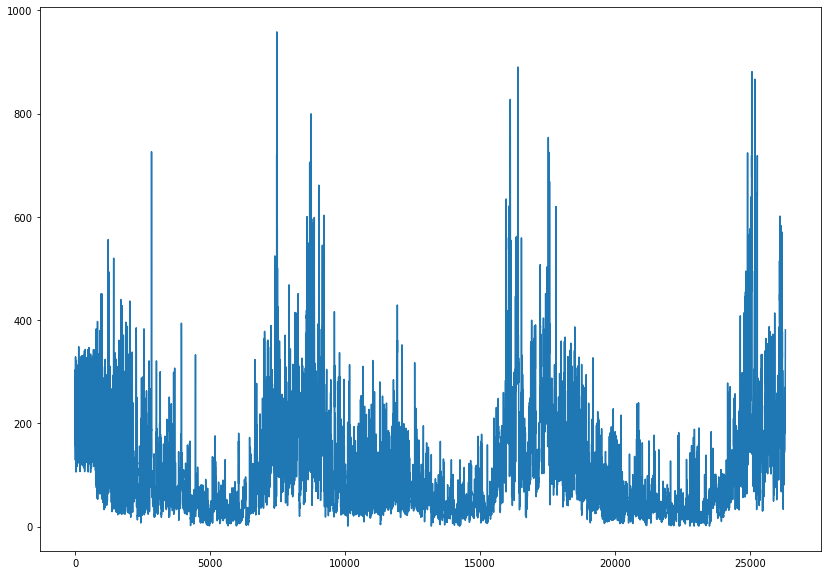

In [6]:
plt.plot(y)

In [7]:
mms_y, scaler = scaled(y)
train, test = splitdata(mms_y)
train.shape

look_back = 35
n_out = 1
units = 28
lr = 0.072
batch_size = 8
model, trainX, testX, trainYb, testYb = fitlstm(train, test, look_back, n_out, units, lr, batch_size)
trainPredict, testPredict = predictfuture(model, trainX, testX)
trainY, testY, trainPredict, testPredict = unscaled(scaler, trainPredict, testPredict, trainYb, testYb)
rmse = rmse_sco(trainY, testY, trainPredict, testPredict)
rmse

Epoch 1/500
2462/2462 - 69s - loss: 0.0028 - val_loss: 0.0020
Epoch 2/500
2462/2462 - 52s - loss: 0.0022 - val_loss: 0.0012
Epoch 3/500
2462/2462 - 58s - loss: 0.0065 - val_loss: 0.0016
Epoch 4/500
2462/2462 - 51s - loss: 0.0029 - val_loss: 0.0012
Epoch 5/500
2462/2462 - 51s - loss: 0.0105 - val_loss: 0.0219
Epoch 6/500
2462/2462 - 52s - loss: 0.0215 - val_loss: 0.0093
Epoch 7/500
2462/2462 - 55s - loss: 0.0101 - val_loss: 0.0096
Epoch 8/500
2462/2462 - 55s - loss: 0.0096 - val_loss: 0.0077
Epoch 9/500
2462/2462 - 52s - loss: 0.0080 - val_loss: 0.0055
Epoch 10/500
2462/2462 - 48s - loss: 0.0075 - val_loss: 0.0040
Epoch 11/500
2462/2462 - 49s - loss: 0.0068 - val_loss: 0.0041
Epoch 12/500
2462/2462 - 47s - loss: 0.0062 - val_loss: 0.0033
Epoch 13/500
2462/2462 - 38s - loss: 0.0060 - val_loss: 0.0039
Epoch 14/500
2462/2462 - 41s - loss: 0.0059 - val_loss: 0.0046
Epoch 15/500
2462/2462 - 34s - loss: 0.0069 - val_loss: 0.0203
Epoch 16/500
2462/2462 - 36s - loss: 0.0172 - val_loss: 0.0219
E

{'trainScore': [151.98320692988307], 'testScore': [141.67697656270963]}

In [8]:
model.save("dwarka_model")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: dwarka_model\assets


In [9]:
trainPredictPlot = np.empty_like(mms_y)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(mms_y)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2): , :] = testPredict

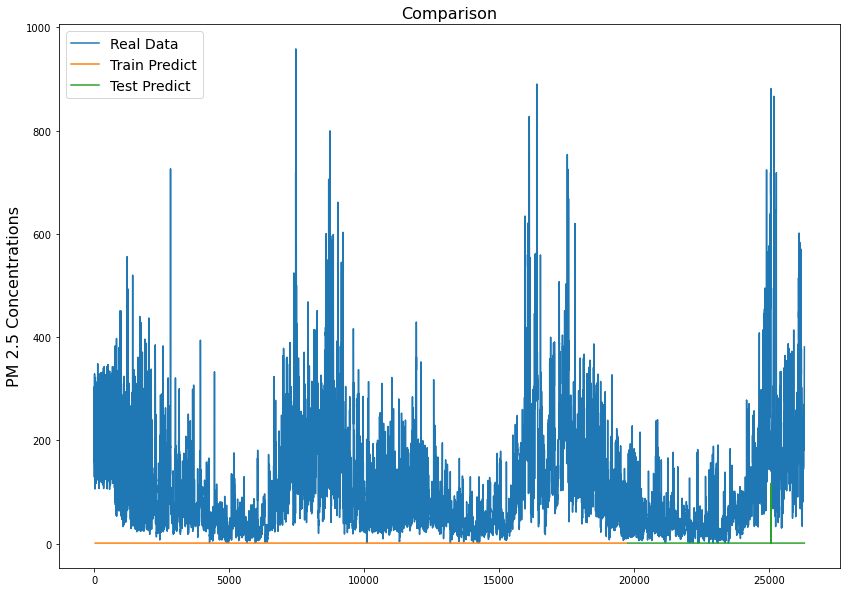

In [10]:
plt.plot(scaler.inverse_transform(mms_y), label = 'Real Data')
plt.plot(trainPredictPlot, label = 'Train Predict')
plt.plot(testPredictPlot, label = 'Test Predict')
plt.ylabel('PM 2.5 Concentrations', fontsize = 16)
plt.title('Comparison', fontsize = 16)
plt.legend(fontsize = 14)
plt.show()
plt.close()

In [11]:
from sklearn.metrics import r2_score
print("test r2 score {}".format(r2_score(testY, testPredict)))
print('train r2 score {}'.format(r2_score(trainY, trainPredict)))

test r2 score -0.7681017481066625
train r2 score -1.2853491223166662


In [12]:
testPredict

array([[1.0000008],
       [1.0000004],
       [1.0000001],
       ...,
       [1.0000131],
       [1.0000112],
       [1.0000111]], dtype=float32)

In [13]:
mms_y

array([[0.24561745],
       [0.2269322 ],
       [0.2179553 ],
       ...,
       [0.36850353],
       [0.3679812 ],
       [0.39697049]])

In [14]:
trainYb.shape

(19695, 1)

In [15]:
trainPredict

array([[1.0000155],
       [1.0000111],
       [1.0000112],
       ...,
       [1.0000005],
       [1.0000006],
       [1.0000006]], dtype=float32)